In [1]:
import folium
import geocoder
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AffinityPropagation
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
import seaborn
seaborn.set()

In [3]:
restaurants = pd.read_csv('../data/data_clean/restaurants.csv')
restaurants.head()

,name,rating,review_count,lat,lng,region
0,A&W,3.2,86,49.238373,-123.031758,Renfrew-Collingwood
1,A&W Canada,3.5,56,49.260988,-123.116495,Fairview
2,A&W Canada,3.8,491,49.262726,-123.069477,Grandview-Woodland
3,A&W Canada,4.1,408,49.219267,-123.040887,Killarney
4,A&W Canada,3.7,312,49.273137,-123.100360,Downtown


--------------------------------------------------------------------------------------------------
Q: Is there a relationship between the population of a region and its number of chain restaurants?

In [4]:
population = pd.read_csv('../data/census2016.csv', comment='#')
regions = restaurants.groupby(by=['region']).size().reset_index(name='chain_restaurant_count')
regions = pd.merge(regions, population, how='inner')
regions = regions.set_index('region')
regions.head()

,chain_restaurant_count,total_population,average_income
region,,,
Arbutus-Ridge,6,15295,62675
Downtown,142,62030,63251
Dunbar-Southlands,4,21425,78117
Fairview,36,33620,61627
Grandview-Woodland,15,29175,42896


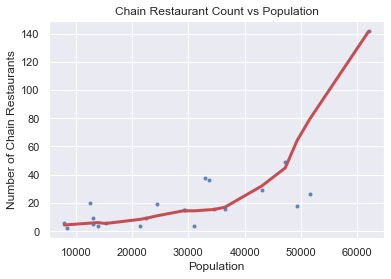

In [5]:
# Visualize data
x = regions['total_population']
y = regions['chain_restaurant_count']
filtered = lowess(y, x, frac=0.4)

fig = plt.figure(figsize=(6,4))
plt.plot(x, y, 'b.', alpha=0.8)
plt.plot(filtered[:, 0], filtered[:, 1], 'r-', linewidth=3)

plt.xlabel("Population")
plt.ylabel("Number of Chain Restaurants")
plt.title('Chain Restaurant Count vs Population')
plt.show()
fig.savefig('../output/restaurant_count_vs_population_untransfromed.jpg', dpi=fig.dpi)

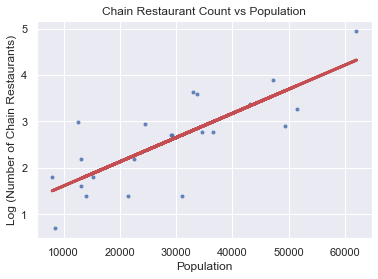

In [6]:
# Transform data to make the relationship linear and perform ordinary least squares regression
fig = plt.figure(figsize=(6,4))

x = regions['total_population']
y = np.log(regions['chain_restaurant_count'])
reg = stats.linregress(x, y)
regions['prediction'] = x*reg.slope + reg.intercept

plt.plot(x, y, 'b.', alpha=0.8)
plt.plot(x, regions['prediction'], 'r-', linewidth=3)
plt.xlabel('Population')
plt.ylabel('Log (Number of Chain Restaurants)')
plt.title('Chain Restaurant Count vs Population')
plt.show()

fig.savefig('../output/restaurant_count_vs_population_transfromed.jpg', dpi=fig.dpi)

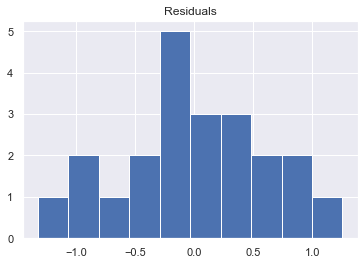

H0: The residuals is normally distributed
Ha: The residuals is not normally distributed

normaltest.pvalue: 0.9657479702293974

We failed to reject H0 since p > 0.05. And therefore the OSL assumption holds.


In [7]:
# Check the OSL assumption that the residuals are normally distributed and mutually independent
reg = stats.linregress(x, y)
residuals = y - (reg.slope*x + reg.intercept)

fig = plt.figure(figsize=(6,4))
plt.hist(residuals)
plt.title('Residuals')
plt.show()
fig.savefig('../output/residuals.jpg', dpi=fig.dpi)

pvalue = stats.normaltest(residuals).pvalue
print("H0: The residuals is normally distributed")
print("Ha: The residuals is not normally distributed\n")
print("normaltest.pvalue: {}\n".format(pvalue))
print("We failed to reject H0 since p > 0.05. And therefore the OSL assumption holds.")

In [8]:
pvalue = reg.pvalue
print("Question(rephrased): Is the slope different from zero?")
print("H0: The slope of the line is zero")
print("Ha: The slope of the line is not zero\n")
print("p-value: {:.6f}\n".format(pvalue))

if (pvalue < 0.05):
    print("Since p < 0.05, we reject the null hypothesis and conclude that the slope of the line is not zero.")
    print("We are 95% confident that there is a relationship between the population of a region and its number of chain restaurants.")
else:
    print("Since p > 0.05, we failed to reject the null hypothesis.")
    print("This test has not identified a consequential relationship between the population of a region and its number of chain restaurants.")

Question(rephrased): Is the slope different from zero?
H0: The slope of the line is zero
Ha: The slope of the line is not zero

p-value: 0.000015

Since p < 0.05, we reject the null hypothesis and conclude that the slope of the line is not zero.
We are 95% confident that there is a relationship between the population of a region and its number of chain restaurants.


 --------------------------------------------------------------------------------------------------
 Q: Does a chain restaurant’s geographical location influence its rating?

In [9]:
restaurants = pd.read_csv('../data/data_clean/restaurants.csv')
restaurants = restaurants[['region','rating']]
rating_by_region = restaurants.groupby(by=['region']).mean()
rating_by_region = rating_by_region.sort_values(by=['rating'])
rating_by_region = rating_by_region.reset_index(level=['region'])
rating_by_region.head()

,region,rating
0,Oakridge,3.488889
1,Kensington-Cedar Cottage,3.627778
2,South Cambie,3.700000
3,Arbutus-Ridge,3.716667
4,Sunset,3.731250


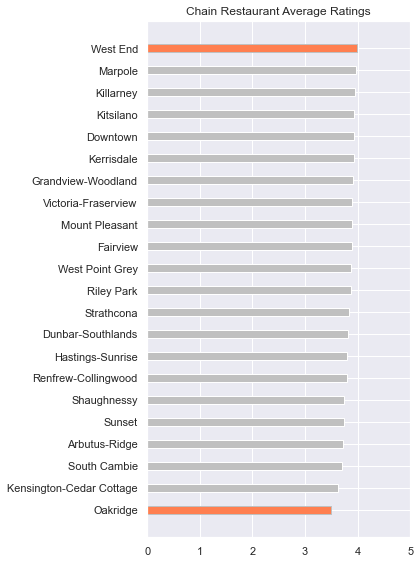

Only 0.51 stars separate the highest and lowest average rating.
Thus we can reasonably conclude a chain restaurant’s geographical location does not influence its rating.


In [10]:
ratings = rating_by_region['rating']
regions = rating_by_region['region']
y_pos = np.arange(len(regions))

# Visualize data
fig = plt.figure(figsize=(6,8))
bars = plt.barh(y_pos, ratings, height=0.35, color='silver')
bars[0].set_color('coral')
bars[0].set_edgecolor("silver")
bars[-1].set_color('coral')
bars[-1].set_edgecolor("silver")
plt.yticks(y_pos, regions)
plt.xticks([0,1,2,3,4,5])
plt.title('Chain Restaurant Average Ratings')
plt.tight_layout()
plt.show()
fig.savefig('../output/average_ratings.jpg', dpi=fig.dpi)

diff = abs(ratings.iloc[0] - ratings.iloc[-1])
print("Only {:.2f} stars separate the highest and lowest average rating.".format(diff))
print("Thus we can reasonably conclude a chain restaurant’s geographical location does not influence its rating.")

--------------------------------------------------------------------------------------------------
Q: How many clusters of chain restaurants are there in Vancouver?

In [11]:
restaurants = pd.read_csv('../data/data_clean/restaurants.csv')
restaurants = restaurants.drop(columns=['rating', 'review_count'])
X = restaurants[['lng', 'lat']].values

model = make_pipeline(
    AffinityPropagation(random_state=5)
)

clusters = model.fit_predict(X)
num_of_clusters = max(clusters) + 1
restaurants['cluster'] = pd.Series(clusters, dtype='int32')

restaurants.head()

,name,lat,lng,region,cluster
0,A&W,49.238373,-123.031758,Renfrew-Collingwood,0
1,A&W Canada,49.260988,-123.116495,Fairview,10
2,A&W Canada,49.262726,-123.069477,Grandview-Woodland,19
3,A&W Canada,49.219267,-123.040887,Killarney,15
4,A&W Canada,49.273137,-123.100360,Downtown,16


In [12]:
print("There are approximately {} clusters of chain restaurants in Vancouver.".format(num_of_clusters))

colors = ['blue','green','orange','red','purple','brown','deeppink','dimgray','olive','crimson',
          'limegreen','cornflowerblue','deeppink','fuchsia','dodgerblue','indigo','darkgoldenrod','aqua','teal','lightcoral']
assert(len(colors) >= num_of_clusters)

m = folium.Map(prefer_canvas=True)

# Plot the restaurant on the map
def plot_restaurant(restaurant):
    name = restaurant['name']
    lat = restaurant['lat']
    lng = restaurant['lng']
    cluster = int(restaurant['cluster'])
    color = colors[cluster]
    folium.CircleMarker(location=[lat,lng], radius=1.2, tooltip=name, color=color, fill=True, fill_color=color).add_to(m)

restaurants.apply(plot_restaurant, axis=1)
folium.LatLngPopup().add_to(m)
m.fit_bounds(m.get_bounds())
display(m)
m.save('../output/clusters.html')

There are approximately 20 clusters of chain restaurants in Vancouver.


--------------------------------------------------------------------------------------------------
Q: Which chain restaurants could be our potential competitors?

In [13]:
# Convert the given address to geolocation
# Return (lat,lng) if successful, return None otherwise
def forward_geocode(address):
    address = address + ', BC, Canada'
    key = 'PlaceYourKeyHere'
    g = geocoder.google(address, key=key)
    if (g.ok):
        return g.latlng
    return None

# Reference: https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula/21623206
def deg2rad(deg):
    return deg * (np.pi/180)

# Return the distance in km between two locations
def haversine(lat1,lon1,lat2,lon2):
    R = 6371
    dLat = deg2rad(lat2-lat1)
    dLon = deg2rad(lon2-lon1)
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(deg2rad(lat1)) * np.cos(deg2rad(lat2)) * np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return round(d,2)

def find_competitors(address, n):
    if n == 0:
        print("The specified number of chain competitors must be greater than zero.")
        return
    
    result = forward_geocode(address)
    if result is None:
        print("Invalid address.")
        return
    lat = result[0]
    lng = result[1]
    
    print("Address: {}".format(address))
    print("Information of {} nearest chain competitors:".format(n))
    
    restaurants = pd.read_csv('../data/data_clean/restaurants.csv')
    locations = restaurants[['lat','lng']].values
    neigh = NearestNeighbors(n_neighbors=n)
    neigh.fit(locations)

    results = neigh.kneighbors([[lat,lng]], return_distance=False)[0]
    
    names = []
    distances = []
    ratings = []
    for i in results:
        competitor = restaurants.iloc[i]
        distance = haversine(lat, lng, competitor['lat'], competitor['lng'])
        names.append(competitor['name'])
        distances.append(distance)
        ratings.append(competitor['rating'])
        
    df = pd.DataFrame(list(zip(names, distances, ratings)), columns =['Name','Distance(km)','Rating']) 
    print(df)
    return

In [14]:
address = "778 Robson Street"
find_competitors(address, 10)

Address: 778 Robson Street
Information of 10 nearest chain competitors:
                              Name  Distance(km)  Rating
0                       A&W Canada          0.00     3.8
1                 Freshslice Pizza          0.01     4.0
2                      Burger King          0.05     3.5
3                       McDonald's          0.13     3.4
4                     Pizza Garden          0.17     4.4
5                           Subway          0.17     4.1
6                        Starbucks          0.16     4.1
7  New York Fries - Pacific Centre          0.17     3.4
8                       A&W Canada          0.17     3.8
9                           Hubbub          0.18     4.3
